#**Revision and Transfer History**


Rev. 0 -- 12/19/25 -- Created by copy in Colab -- Google Drive -- Duck Browser

       -- Search and Replace fair with hapmar (Happiness of Marriage)
       
Rev. 1 -- 12/19/25 --Work the notebook in VS Code on WSL







# Political Alignment and Outlook -- Happy Marriage

This is the third in a series of notebooks that make up a [case study in exploratory data analysis](https://allendowney.github.io/PoliticalAlignmentCaseStudy/).
This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.
[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/PoliticalAlignmentCaseStudy/blob/v1/03_outlook.ipynb).

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/utils.py')

In the previous chapter, we used data from the General Social Survey (GSS) to plot changes in political alignment over time.
In this chapter, we'll explore the relationship between political alignment and respondents' beliefs about themselves and other people.
We'll use the following variables from the GSS dataset:

* `hapmar`: happiness of marriage :  Taking all things together, how would you describe your marriage?  Would you say that your marriage is very happy, pretty happy, or not too happy?

Here's the plan:

1. First we'll use `groupby` to compare responses between groups and plot changes over time.

2. We'll use the Pandas function `pivot_table` to explore differences between groups over time.

3. Finally, we'll use resampling to see whether the features we see in the results might be due to randomness, or whether they are likely to reflect actual changes in the world.

If everything we need is installed, the following cell should run without error.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The following cells import functions from the previous chapter that we'll use again.

In [7]:
from utils import values, decorate, make_lowess, plot_series_lowess, plot_columns_lowess

The following cell downloads the data file if necessary.

In [4]:
download(
    'https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/gss_pacs_resampled.hdf'
)

We'll use an extract of the data that I have cleaned and resampled to correct for stratified sampling.
Instructions for downloading the file are in the notebook for this chapter.
It contains three resamplings -- we'll use the first, `gss0`, to get started.
At the end of the chapter, we'll use the other two as well.

In [8]:
datafile = 'gss_pacs_resampled.hdf'
gss = pd.read_hdf(datafile, key='gss0')
gss.shape

(72390, 207)

## Happiness of Marriage

In the GSS data, the variable `hapmar` contains responses to this question:

> Taking all things together, how would you describe your marriage?  Would you say that your marriage is very happy, pretty happy, or not too happy?

The possible responses are:

| Code   | Response                      |
|--------|:------------------------------|
| -100   | Inapplicable                  |
| -99    | No answer                     |
| -98    | No Do not know/ cannot choose |
| -97    | Skipped on Web                |
| 1      | VERY HAPPY                    |
| 2      | PRETTY HAPPY                  |
| 3      | NOT TOO HAPPY                 |

We can use `values`, from the previous chapter, to see how many people gave each response.

In [9]:
values(gss['hapmar'])

hapmar
1.0    24234
2.0    13202
3.0     1175
Name: count, dtype: int64

The majority of people report being VERY HAPPY in their marriage.

In [10]:
hapmar_map = {1: 1, 2: 2, 3: 3} # Not really needed, but sticking with template.

We can use `replace` to recode the values and store the result as a new column in the `DataFrame`.

In [11]:
gss['hapmar2'] = gss['hapmar'].replace(hapmar_map)

And we'll use `values` to make sure it worked.

In [12]:
values(gss['hapmar2'])

hapmar2
1.0    24234
2.0    13202
3.0     1175
Name: count, dtype: int64

Now let's see how the responses have changed over time.

## Marriage Happiness Over Time

As we saw in the previous chapter, we can use `groupby` to group responses by year.

In [13]:
gss_by_year = gss.groupby('year')

From the result we can select `hapmar2` and compute the mean.

In [14]:
hapmar_by_year = gss_by_year['hapmar2'].mean()

Here's the result, which shows the fraction of people who say people try to be fair, plotted over time.
As in the previous chapter, we plot the data points themselves with circles and a local regression model as a line.

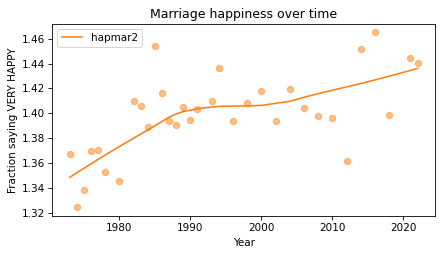

In [16]:
plot_series_lowess(hapmar_by_year, 'C1')

decorate(
    xlabel='Year',
    ylabel='Fraction saying VERY HAPPY',
    title='Marriage happiness over time',
)

It looks like happiness is improving, NEED TO CLARIFY Y AXIS SCALE!
Let's see what this trend looks like if we group the respondents by political alignment.

## Political Views on a 3-point Scale

In the previous notebook, we looked at responses to `polviews`, which asks about political alignment.
To make it easier to visualize groups, we'll lump the 7-point scale into a 3-point scale.

In [17]:
polviews_map = {
    1: 'Liberal',
    2: 'Liberal',
    3: 'Liberal',
    4: 'Moderate',
    5: 'Conservative',
    6: 'Conservative',
    7: 'Conservative',
}

We'll use `replace` again, and store the result as a new column in the `DataFrame`.

In [18]:
gss['polviews3'] = gss['polviews'].replace(polviews_map)

With this scale, there are roughly the same number of people in each group.

In [19]:
values(gss['polviews3'])

polviews3
Conservative    21573
Liberal         17203
Moderate        24157
Name: count, dtype: int64

## Happiness by Group

Now let's see who is more happy, conservatives or liberals.
We'll group the respondents by `polviews3`.

In [20]:
by_polviews = gss.groupby('polviews3')

And compute the mean of `hapmar2` in each group.

In [21]:
by_polviews['hapmar2'].mean()

polviews3
Conservative    1.366252
Liberal         1.426104
Moderate        1.419659
Name: hapmar2, dtype: float64

It looks like liberals and moderates are happier than conservatives.
But this result is averaged over the last 50 years.
Let's see how things have changed over time.

## Marriage Happiness over Time by Group

So far, we have grouped by `polviews3` and computed the mean of `hapmar2` in each group.
Then we grouped by `year` and computed the mean of `hapmar2` for each year.
Now we'll group by `polviews3` and `year`, and compute the mean of `hapmar2` in each group over time.

We could do that computation using the tools we already have, but it is so common and useful that it has a name.
It is called a **pivot table**, and Pandas provides a function called `pivot_table` that computes it.
It takes the following arguments:

* `index`, which is the name of the variable that will provide the row labels: `year` in this example.

* `columns`, which is the name of the variable that will provide the column labels: `polviews3` in this example.

* `values`, which is the name of the variable we want to summarize: `hapmar2` in this example.

* `aggfunc`, which is the function used to "aggregate", or summarize, the values: `mean` in this example.

Here's how we run it.

In [22]:
table = gss.pivot_table(
    index='year', columns='polviews3', values='hapmar2', aggfunc='mean'
)

The result is a `DataFrame` that has years running down the rows and political alignment running across the columns.
Each entry in the table is the mean of `hapmar2` for a given group in a given year.

In [23]:
table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,1.259036,1.368932,1.316547
1975,1.379195,1.335616,1.273585
1976,1.289157,1.383142,1.412195
1977,1.380117,1.385455,1.352381
1978,1.238636,1.461224,1.382500


Reading across the first row, we can see that in 1975, liberals were the happiest followed by moderates, with conservatives coming in third place.
Reading down the first column, we can see that the estimated mean of `hapmar2` among conservatives varies from year to year.  It is hard to tell by looking at these numbers whether it is trending up or down -- we can get a better view by plotting the results.

## Plotting the Results

Before we plot the results, I'll make a dictionary that maps from each group to a color.
Seaborn provide a palette called `muted` that contains the colors we'll use.

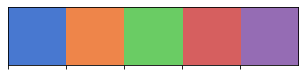

In [24]:
muted = sns.color_palette('muted', 5)
sns.palplot(muted)

And here's the dictionary.

In [25]:
color_map = {'Conservative': muted[3],
             'Moderate': muted[4],
             'Liberal': muted[0]}

Now we can plot the results.

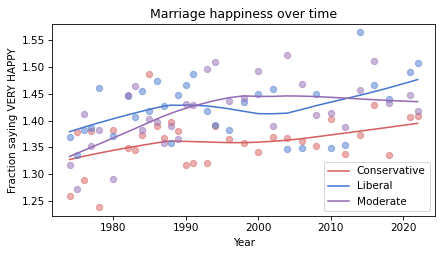

In [26]:
groups = ['Conservative', 'Liberal', 'Moderate']

for group in groups:
    plot_series_lowess(table[group], color_map[group])

decorate(
    xlabel='Year',
    ylabel='Fraction saying VERY HAPPY',
    title='Marriage happiness over time',
)

Overall conservatives tend to be less happy in their marriages over time with liberals and moderates swapping back and forth.
All groups showed a slight upward trend in happiness over time.

FOLLOW-UP:  How does that relate to divorce rate?

We can get a sense of how reliable they are by running the resampling process a few times and checking how much the results vary.

## Simulating Possible Datasets

The figures we have generated so far are based on a single resampling of the GSS data.
Some of the features we see in these figures might be due to random sampling rather than actual changes in the world.
By generating the same figures with different resampled datasets, we can get a sense of how much variation there is due to random sampling.

To make that easier, the following function contains the code from the previous analysis all in one place.

In [29]:
def plot_by_polviews(gss):
    '''Plot mean response by polviews and year.

    gss: DataFrame
    '''
    gss['polviews3'] = gss['polviews'].replace(polviews_map)
    gss['hapmar2'] = gss['hapmar'].replace(hapmar_map)

    table = gss.pivot_table(
        index='year', columns='polviews3', values='hapmar2', aggfunc='mean'
    )

    for group in groups:
        plot_series_lowess(table[group], color_map[group])

    decorate(
        xlabel='Year',
        ylabel='Fraction saying VERY HAPPY',
        title='Marriage happiness over time',
    )

Now we can loop through the three resampled datasets in the data file and generate a figure for each one.

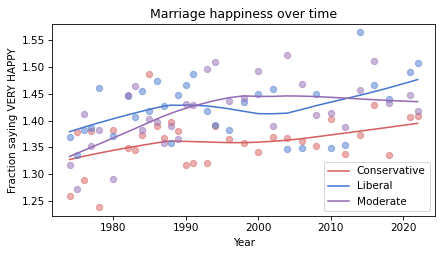

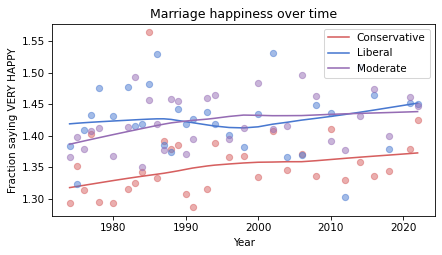

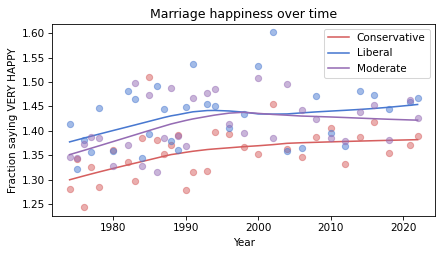

In [30]:
datafile = 'gss_pacs_resampled.hdf'

for key in ['gss0', 'gss1', 'gss2']:
    df = pd.read_hdf(datafile, key)
    plt.figure()
    plot_by_polviews(df)

Features that are the same in all three figures are more likely to reflect things actually happening in the world.
Features that differ substantially between the figures are more likely to be due to random sampling.

**Exercise:** You can run the same analysis with one of the other variables related to outlook: `happy`, `trust`, `helpful`, and maybe `fear` and `hapmar`.

For these variables, you will have to read the codebook to see the responses and how they are encoded, then think about which responses to report.
In the notebook for this chapter, there are some suggestions to get you started.

Here are the steps I suggest:
    
1) If you have not already saved this notebook, you might want to do that first. If you are running on Colab, select "Save a copy in Drive" from the File menu.

2) Now, before you modify this notebook, make another copy and give it an appropriate name.

3) Search and replace `fair` with the name of the variable you select (use "Edit->Find and replace").

4) Run the notebook from the beginning and see what other changes you have to make.

Write a few sentences to describe the relationships you find between political alignment and outlook.

## Summary

The case study in this chapter and the previous one demonstrates a process for exploring a dataset and finding relationships among the variables.

In the previous chapter, we started with a single variable, `polviews`, and visualized its distribution at the beginning and end of the observation interval.
Then we used `groupby` to see how the mean and standard deviation changed over time.
Looking more closely, we used cross tabulation to see how the fraction of people in each group changed.

In this chapter, we added a second variable, `fair`, which is one of several questions in the GSS related to respondents' beliefs about other people.
We used `groupby` again to see how the responses have changed over time.
Then we used a pivot table to show how the responses within each political group have changed.
Finally, we used multiple resamplings of the original dataset to check whether the patterns we identified might be due to random sampling rather than real changes in the world.

The tools we used in this case study are versatile -- they are useful for exploring other variables in the GSS dataset, and other datasets as well.
And the process we followed is one I recommend whenever you are exploring a new dataset.

Political Alignment Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)